# Malaria Detection

In this notebook I will be building a model for detecting malaria from images of blood cells. The dataset of 27,558 cell images (equal amounts of parasitized and uninfected) were taken from Giemsa-stained thin blood smear slides.

The dataset and more information can be found at https://ceb.nlm.nih.gov/repositories/malaria-datasets/

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
import random
import pathlib
import itertools
from sklearn.metrics import confusion_matrix

tf.__version__

'2.0.0-beta0'

#### Creating lists of paths to images.

In [259]:
base_path = "...\\cell-images-for-detecting-malaria\\cell_images\\"

data_root_infected = pathlib.Path(base_path + "Parasitized\\")
data_root_uninfected = pathlib.Path(base_path + "Uninfected\\")

all_infected_paths = list(data_root_infected.glob('*.png'))
all_infected_paths = [str(path) for path in all_infected_paths]

all_uninfected_paths = list(data_root_uninfected.glob('*.png'))
all_uninfected_paths = [str(path) for path in all_uninfected_paths]


#### Image preprocessing functions.

In [4]:
size = 55

def preprocess_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [size, size])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#### Preprocessing images and creating labels.  The dataset is quite small, so I am using data augmentation to create more images using rotations and random flipping.

In [253]:
cell_images = []
cell_labels = []

for item in all_infected_paths:
    final_image = load_and_preprocess_image(item)
    rotated_image = tf.image.rot90(final_image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    flipped_image = tf.image.random_flip_left_right(final_image)
    flipped_image = tf.image.random_flip_up_down(flipped_image)
    cell_images.append(final_image)
    cell_images.append(rotated_image)
    cell_images.append(flipped_image)
    cell_labels.append(1)
    cell_labels.append(1)
    cell_labels.append(1)
    
for item in all_uninfected_paths:
    final_image = load_and_preprocess_image(item)
    rotated_image = tf.image.rot90(final_image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    flipped_image = tf.image.random_flip_left_right(final_image)
    flipped_image = tf.image.random_flip_up_down(flipped_image)
    cell_images.append(final_image)
    cell_images.append(rotated_image)
    cell_images.append(flipped_image)
    cell_labels.append(0)
    cell_labels.append(0)
    cell_labels.append(0)

In [256]:
print("Cell Images: ", len(cell_images))

Cell Images: 82,674


### Visualizing the data
We can see a few of the images after preprocessing and augmentation.  It seems that the blood cells infected with malaria tend to have concentrations of discoloration.  A convolutional neural network should do well at learning these features.

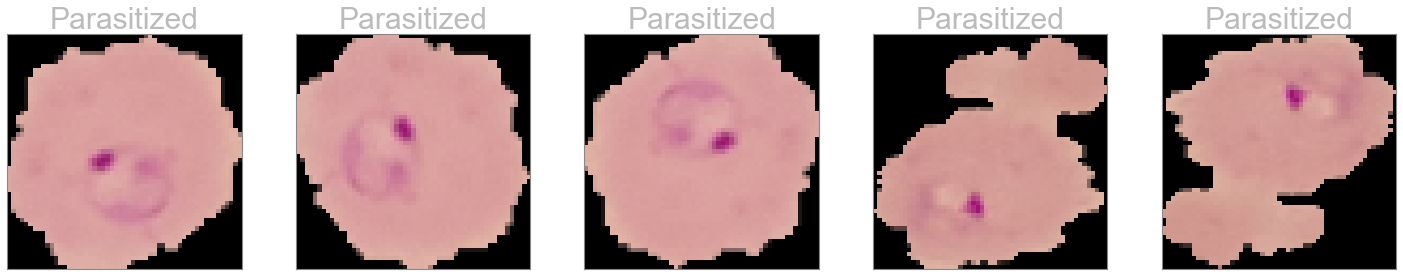

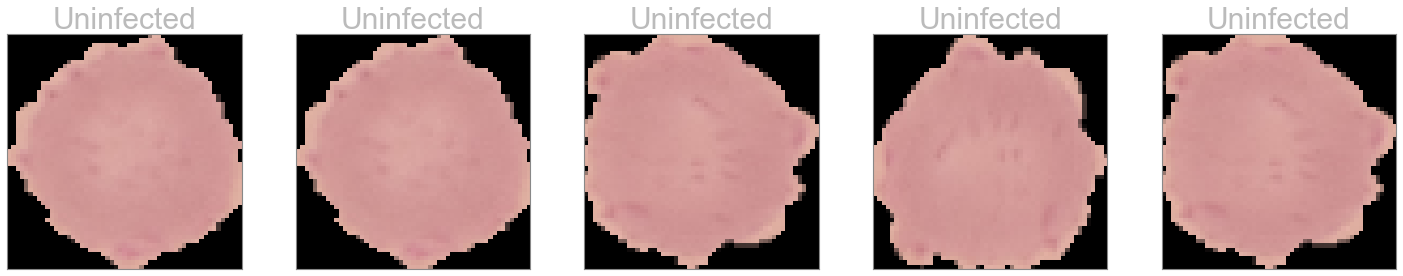

In [250]:
def visualize_images(imgs, title):    
    plt.figure(figsize=(25,25))
    for i in range(5):
        plt.subplot(5,5, i+1)
        plt.imshow(imgs[i])
        plt.title(title,fontsize=30)
        plt.xticks([]) , plt.yticks([])
    plt.show()

visualize_images(cell_images, "Parasitized")
visualize_images(cell_images[len(cell_images)-5:], "Uninfected")

#### Converting into numpy arrays.

In [35]:
cells=np.array(cell_images)
labels=np.array(cell_labels)

#### Shuffling images and labels in the same order.

In [36]:
r=np.arange(cells.shape[0])
np.random.shuffle(r)
cells=cells[r]
labels=labels[r]

#### Creating train/dev/test split.  80/10/10

In [248]:
split_1 = int(0.8 * len(labels))
split_2 = int(0.9 * len(labels))

train_images = cells[:split_1]
train_labels = labels[:split_1]
val_images = cells[split_1:split_2]
val_labels = labels[split_1:split_2]
test_images = cells[split_2:]
test_labels = labels[split_2:]

train_image_count = len(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))

66139
8267
8268


### Creating the Model.
I experimented with a quite a few different architectures, but this relatively simple model proved to give the best results.  Batch Normalization and data augmentation both helped reduce overfitting.  Multiple fully connected layers didn't improve performance.  A higher number of filters only increased training time and overfitting.

In [53]:
model = models.Sequential([
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(55,55,3), padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(
               learning_rate=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-07),
               loss='binary_crossentropy',
               metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 55, 55, 32)        416       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 27, 27, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 64)       

#### Training model.

In [54]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=50, verbose=1, validation_data=(val_images,val_labels))

Train on 66139 samples, validate on 8267 samples
Epoch 1/50
66139/66139 [==============================] - 36s 545us/sample - loss: 0.1895 - accuracy: 0.9299 - val_loss: 0.1333 - val_accuracy: 0.9608
Epoch 2/50
66139/66139 [==============================] - 35s 523us/sample - loss: 0.1130 - accuracy: 0.9607 - val_loss: 0.1126 - val_accuracy: 0.9644
Epoch 3/50
66139/66139 [==============================] - 35s 524us/sample - loss: 0.0956 - accuracy: 0.9673 - val_loss: 0.1068 - val_accuracy: 0.9665
Epoch 4/50
66139/66139 [==============================] - 35s 525us/sample - loss: 0.0831 - accuracy: 0.9709 - val_loss: 0.1297 - val_accuracy: 0.9560
Epoch 5/50
66139/66139 [==============================] - 35s 525us/sample - loss: 0.0704 - accuracy: 0.9762 - val_loss: 0.1058 - val_accuracy: 0.9648
Epoch 6/50
66139/66139 [==============================] - 35s 525us/sample - loss: 0.0577 - accuracy: 0.9803 - val_loss: 0.1020 - val_accuracy: 0.9678
Epoch 7/50
66139/66139 [=====================

#### Testing model on unseen data.  ~97.5% accuracy.  Not bad!

In [55]:
accuracy, loss = model.evaluate(test_images, test_labels)

8268/8268 [==============================] - 2s 278us/sample - loss: 0.2109 - accuracy: 0.9748


In [214]:
predictions = model.predict(test_images)

#### Plotting confusion matrix.  Untreated malaria can be deadly.  We would like to see very low amounts of false negatives.

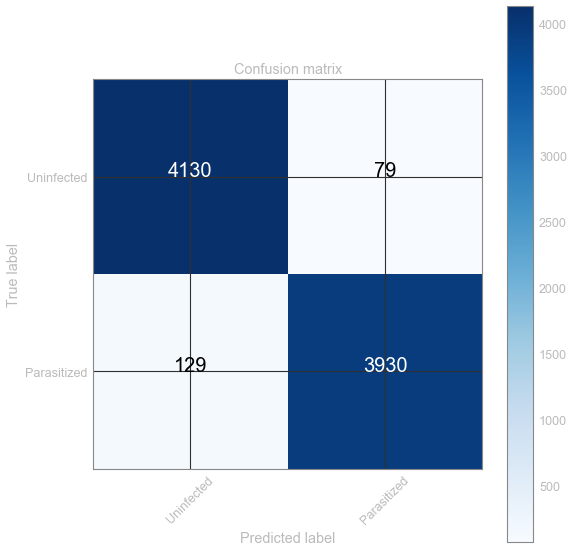

In [296]:
cm = confusion_matrix(test_labels, tf.round(predictions))
label_names = ['Uninfected','Parasitized']

figure = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=45)
plt.yticks(tick_marks, label_names)

# Use white text if squares are dark; otherwise black.
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color, fontsize=20)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Separating predictions into lists of true negatives, true positives, fasle negatives, and false positives.

In [301]:
tn_images = []
test_tn_labels = []
tn_labels = []

tp_images = []
test_tp_labels = []
tp_labels = []

fn_images = []
test_fn_labels = []
fn_labels = []

fp_images = []
test_fp_labels = []
fp_labels = []

for i in range(len(test_images)):
    if test_labels[i] == 0 and np.around(predictions[i]) == 0:
        tn_images.append(test_images[i])
        test_tn_labels.append(test_labels[i])
        tn_labels.append(int(predictions[i]))
    elif test_labels[i] == 1 and np.around(predictions[i]) == 1:
        tp_images.append(test_images[i])
        test_tp_labels.append(test_labels[i])
        tp_labels.append(np.around(predictions[i]))
    elif test_labels[i] > np.around(predictions[i]):
        fn_images.append(test_images[i])
        test_fn_labels.append(test_labels[i])
        fn_labels.append(np.around(predictions[i]))      
    else:
        fp_images.append(test_images[i])
        test_fp_labels.append(test_labels[i])
        fp_labels.append(np.around(predictions[i]))

In [303]:
def visualize_predictions(imgs, true_labels, predicted_labels, title):    
    plt.figure(1, figsize=(25,25))
    for i in range(5):
        plt.subplot(5,5, i+1)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        plt.imshow(imgs[i])
        plt.title('True {} : Pred {}'.format(true_labels[i], int(predicted_labels[i])), fontsize=25)
        plt.suptitle(title, fontsize=35)
        plt.xticks([]) , plt.yticks([])
    plt.show()

#### Visualizing Predictions.
It looks like the model struggles to predict the presence of malaria when there are only small amounts of discoloration, or if the cell is uniformly discolored. 

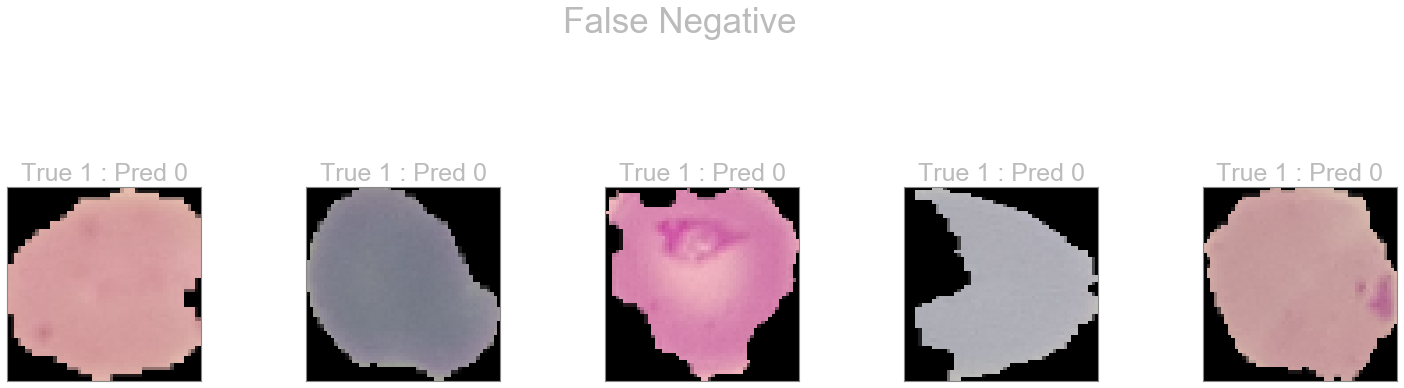

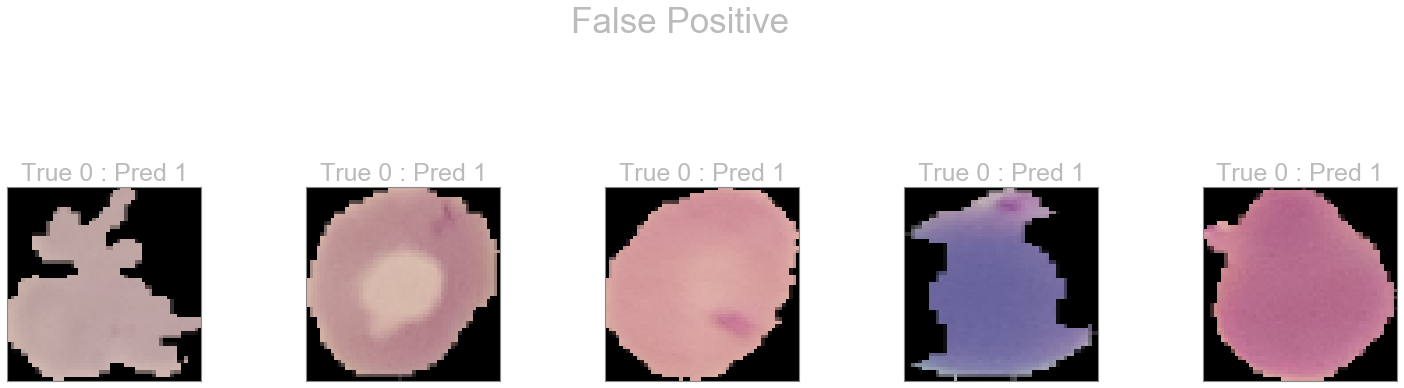

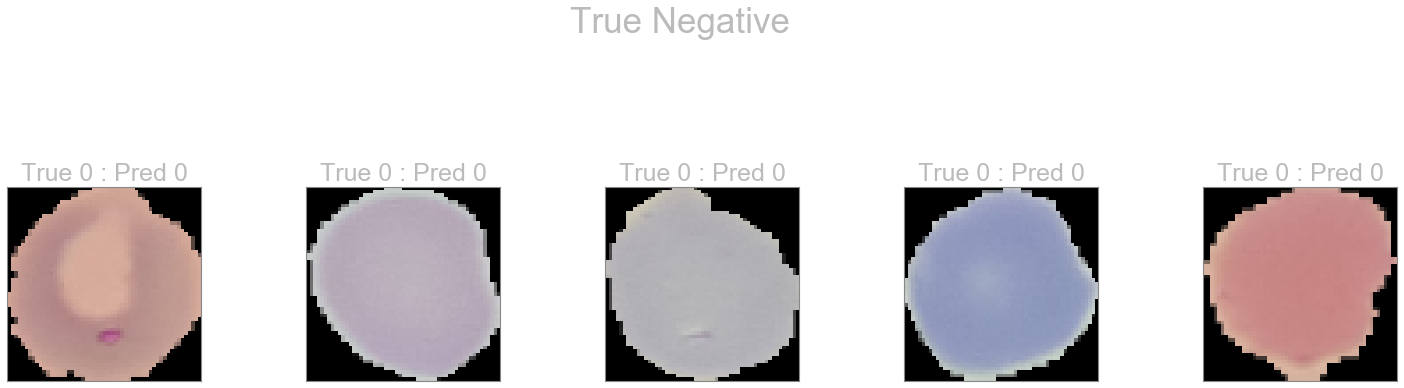

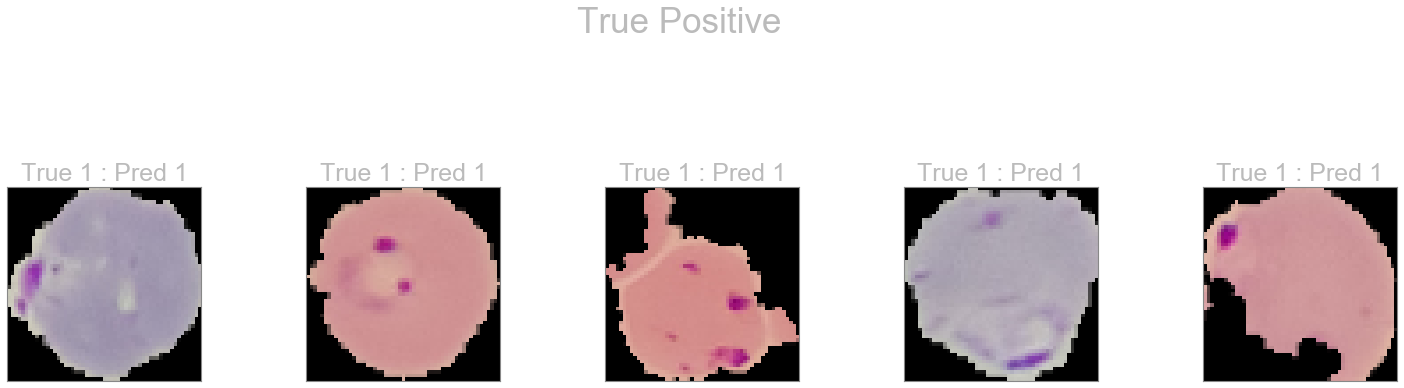

In [305]:
visualize_predictions(fn_images, test_fn_labels, fn_labels, "False Negative")
visualize_predictions(fp_images, test_fp_labels, fp_labels, "False Positive")
visualize_predictions(tn_images, test_tn_labels, tn_labels, "True Negative")
visualize_predictions(tp_images, test_tp_labels, tp_labels, "True Positive")